In [1]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))
    
fix_layout()

In [2]:
import os
import h5py
import sys
sys.path.append("../..") 
import numpy as np
from cryoem.quaternions import euler2quaternion, d_q, quaternion2euler
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow_graphics.geometry.transformation import quaternion
from time import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white", color_codes=True)
import random
from tensorflow_graphics.math import vector
from itertools import product

from cryoem.angle_alignment import distance_difference

In [3]:
PROTEIN="5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")
      
angles_true = np.array(data['Angles'])
projections = data['Projections']
      

5000 projections of images with dimension (275, 275) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [4]:
#ap_mod = np.load("predicted_angles_mod.npy")
ap = np.load("data/predicted_angles.npy")

In [5]:
distance_difference(angles_predicted=ap, angles_true=angles_true)

Mean quaternion distance between true and predicted values:  1.820303758799054  rad ( 104.29572281098558  degrees)


1.820303758799054

---

---

\begin{equation}
\label{eq:phase1}
\operatorname*{min}_{R  \in SO(4), m \in \{-1,1\}} \frac{1}{n} \sum_{i=1} d_q(q_i, R \begin{bmatrix}
m & 0\\
0 & I
\end{bmatrix} \hat{q_i})
\end{equation}

- $d_q$ is the distance between two quaternions

- $q_i \in S^3$ is the quaternion of a true rotation angles

- $\hat{q_i} \in S^3$ is the rotation of the estimatied rotation angles

- $R \in SO(4)$ is $4x4$ orthogonal matrix with determinant 1 that represents a global rotation

- $m \in \{-1,1\}$ represents a global reflection ($m=1$ no reflection, $m=-1$ reflection)

- $\begin{bmatrix}
m & 0\\
0 & I
\end{bmatrix} = \begin{bmatrix}
m & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1
\end{bmatrix}$

In [6]:
from cryoem.quaternions import euler2quaternion

In [23]:
def euler6tomarix4d(a_R):
    a, b, g, l, t, p = tf.unstack(a_R, axis=-1)
    
    ca = tf.cos(a)
    cb = tf.cos(b)
    cg = tf.cos(g)
    cl = tf.cos(l)
    ct = tf.cos(t)
    cp = tf.cos(p)
    
    sa = tf.sin(a)
    sb = tf.sin(b)
    sg = tf.sin(g)
    sl = tf.sin(l)
    st = tf.sin(t)
    sp = tf.sin(p)

   

    Ra = tf.concat([ [tf.concat([ tf.complex([1.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([1.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex(   ca, 0.0), tf.complex(  -sa, 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex(   sa, 0.0), tf.complex(   ca, 0.0)], axis=0)]], axis=0)

    Rb = tf.concat([ [tf.concat([ tf.complex([1.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex(   cb, 0.0), tf.complex([0.0], 0.0), tf.complex(   sb, 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([1.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex(  -sb, 0.0), tf.complex([0.0], 0.0), tf.complex(   cb, 0.0)], axis=0)]], axis=0)
    
    Rg = tf.concat([ [tf.concat([ tf.complex([1.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex( cg, 0.0), tf.complex(-sg, 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex( sg, 0.0), tf.complex( cg, 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([1.0], 0.0)], axis=0)]], axis=0)
    
    Rl = tf.concat([ [tf.concat([ tf.complex( cl, 0.0), tf.complex([0.0], -sl), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], -sl), tf.complex( cl, 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([1.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([1.0], 0.0)], axis=0)]], axis=0)
    
    Rt = tf.concat([ [tf.concat([ tf.complex( ct, 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], -st), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([1.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], -st), tf.complex([0.0], 0.0), tf.complex( ct, 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([1.0], 0.0)], axis=0)]], axis=0)
    
    Rp = tf.concat([ [tf.concat([ tf.complex( cp, 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], -sp)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([1.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([1.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], -sp), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex(cp, 0.0)], axis=0)]], axis=0)
    
    R = Ra @ Rb @ Rg @ Rl @ Rt @ Rp
    
    
    return R
    
    

def from3to4(mat):
    fill1 = tf.reshape([[0.0,0.0,0.0]]*mat.shape[0], (-1,3,1))
    mat_4d = tf.concat([fill1, mat], axis=2)
    fill2 = tf.reshape([[1.0,0.0,0.0,0.0]]*mat_4d.shape[0], (-1,1,4))
    out = tf.concat([fill2, mat_4d], axis=1)
    return tf.cast(out, dtype=tf.complex64)


def loss_alignment(m, a_R, a_predicted, a_true):
    qi = euler2quaternion(a_true)
    qi_est = euler2quaternion(a_predicted)
    
    R = euler6tomarix4d(a_R)
    
    I = tf.concat([ [tf.concat([tf.complex([m], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([tf.complex([0.0], 0.0), tf.complex([1.0],0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([1.0], 0.0), tf.complex([0.0], 0.0)], axis=0)], 
                     [tf.concat([tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([1.0], 0.0)], axis=0)]], axis=0)

    R = tf.cast(R, dtype=tf.complex64)
    I = tf.cast(I, dtype=tf.complex64)
    qi_est = tf.cast(qi_est, dtype=tf.complex64)

    second = tf.transpose(R @ I @ tf.transpose(qi_est))
    second = tf.cast(second, dtype=tf.float64)

    distance = d_q(qi, second)
    
    return tf.reduce_mean(distance)


def gradient_alignment(m, a_R, a_predicted, a_true):
    with tf.GradientTape() as tape:
        loss_value = loss_alignment(m, a_R, a_predicted, a_true)
        gradient = tape.gradient(loss_value, a_R)
        
    return loss_value, gradient


def training_angle_alignment(steps, batch_size, projection_idx, learning_rate, angles_true, angles_predicted, optimization=True):
    optimizer = Adam(learning_rate=learning_rate)
    
    time_start = time()

    # collect rotations
    r = []
    # collect losses depending on rotation
    l = []
    ms = [-1.0, 1.0]

    for m in ms:
        losses = np.empty(steps)
        angles_predicted = tf.convert_to_tensor(ap)
    
        euler = np.zeros(6, dtype=np.float32)
        a_R = [tf.Variable(euler)]
        
        for step in range(1, steps+1):

            # Sample some pairs.
            idx = list(np.random.choice(projection_idx, size=batch_size))

            # Compute distances between projections
            a_true      = [angles_true[i]      for i in idx]
            a_predicted = [angles_predicted[i] for i in idx]

            # Optimize by gradient descent.
            if optimization:
                losses[step-1], gradients = gradient_alignment(m, a_R, a_predicted, a_true)
                optimizer.apply_gradients(zip(gradients, a_R))
            else:
                losses[step-1] = loss_alignment(m, a_R, a_predicted, a_true)

            # Periodically report progress.
            if ((step % (steps//10)) == 0) or (step == steps):
                time_elapsed = time() - time_start
                print(f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}')
        print("-"*20)
        if optimization:
            # Plot convergence.
            fig, ax = plt.subplots()
            ax.plot(np.linspace(0, time()-time_start, steps), losses)
            ax.set_xlabel('time [s]')
            ax.set_ylabel('loss');
        else:
            print(f"Mean distance difference: {np.mean(losses)}")
         
        r.append(a_R)
        l.append(losses[-1])
        
    for i, m in enumerate([-1, 1]):
        print(f"For m={m}, loss is: {l[i]}")
    
    idx_best = np.argmin(np.array(l))
    return ms[idx_best], r[idx_best], l[idx_best]


step 1000/10000 (93s): loss = 1.79e+00
step 2000/10000 (189s): loss = 1.86e+00
step 3000/10000 (285s): loss = 1.91e+00
step 4000/10000 (386s): loss = 1.81e+00
step 5000/10000 (485s): loss = 1.83e+00
step 6000/10000 (585s): loss = 1.85e+00
step 7000/10000 (689s): loss = 1.80e+00
step 8000/10000 (789s): loss = 1.90e+00
step 9000/10000 (888s): loss = 1.90e+00
step 10000/10000 (987s): loss = 1.87e+00
--------------------
step 1000/10000 (1090s): loss = 1.89e+00
step 2000/10000 (1190s): loss = 1.90e+00
step 3000/10000 (1290s): loss = 1.84e+00
step 4000/10000 (1394s): loss = 1.80e+00
step 5000/10000 (1497s): loss = 1.77e+00
step 6000/10000 (1599s): loss = 1.81e+00
step 7000/10000 (1701s): loss = 1.72e+00
step 8000/10000 (1803s): loss = 1.84e+00
step 9000/10000 (1907s): loss = 1.90e+00
step 10000/10000 (2012s): loss = 1.82e+00
--------------------
For m=-1, loss is: 1.8650885165640099
For m=1, loss is: 1.8246592081315587


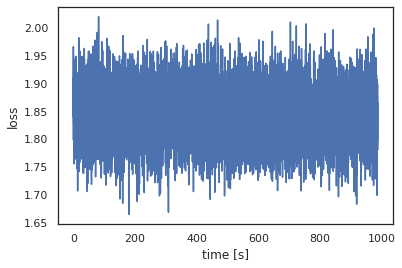

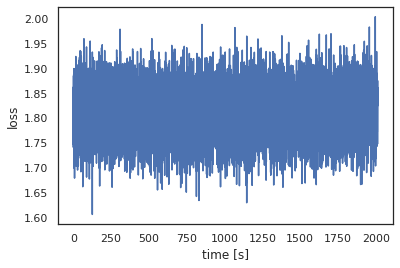

In [24]:
m, rotation, loss = training_angle_alignment(steps=10000, 
                         batch_size=256, 
                         projection_idx=range(NUM_PROJECTIONS), 
                         learning_rate=0.01, 
                         angles_true=angles_true, 
                         angles_predicted=ap, 
                         optimization=True)

In [26]:
m, rotation, loss

(1.0, [<tf.Variable 'Variable:0' shape=(6,) dtype=float32, numpy=
  array([-0.8778959 ,  0.04368864, -0.03397216,  0.        ,  0.        ,
          0.        ], dtype=float32)>], 1.8246592081315587)

In [30]:
from cryoem.quaternions import quaternion2euler

In [33]:
def update_angles(m, a_R, a_predicted):
    #Ri = tf.cast(euler2matrix(a_true), dtype=tf.float32)
    #Ri_est = tf.cast(euler2matrix(a_predicted), dtype=tf.float32)
    #qi = euler2quaternion(a_true)
    qi_est = euler2quaternion(a_predicted)
    
    #Ri_4d = from3to4(Ri)
    #Ri_est_4d = from3to4(Ri_est)
    R = euler6tomarix4d(a_R)
    
    I = tf.concat([ [tf.concat([tf.complex([m], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([tf.complex([0.0], 0.0), tf.complex([1.0],0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([1.0], 0.0), tf.complex([0.0], 0.0)], axis=0)], 
                     [tf.concat([tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([1.0], 0.0)], axis=0)]], axis=0)

    R = tf.cast(R, dtype=tf.complex64)
    I = tf.cast(I, dtype=tf.complex64)
    qi_est = tf.cast(qi_est, dtype=tf.complex64)

    second = tf.transpose(R @ I @ tf.transpose(qi_est))
    second = tf.cast(second, dtype=tf.float64)
    
    return quaternion2euler(second)

In [34]:
# def matrix2euler(mat):
    
#     def _inner(m):
#         if m[2,2] < 1:
#             if m[2,2] > -1:
#                 a2 = tf.acos(m[2,2])
#                 a1 = tf.atan2(m[1,2], m[0,2])
#                 a3 = tf.atan2(m[2,1], -m[2,0])
#             else:
#                 a2 = tf.math.pi
#                 a1 = -tf.atan2(m[1,0], m[1,1])
#                 a3 = 0
#         else:
#             a2 = 0
#             a1 = tf.atan2(m[1,0], m[1,1])
#             a3 = 0
            
#         return tf.stack([a1, a2, a3], axis=0)
    
#     # TODO: WHAT TO DO WITH -1?? It is just cut bellow!!!!
    
#     mat_vecs = tf.unstack(mat, axis=1)
#     del mat_vecs[0]
#     mat = tf.stack(mat_vecs, 1)
    
#     mat_vecs = tf.unstack(mat, axis=2)
#     del mat_vecs[0]
#     mat = tf.stack(mat_vecs, axis=2)
    
#     #print(mat)
    
#     angles = []
#     for m in mat:
#         angles.append(_inner(m).numpy())

#     return np.array(angles)

In [35]:
mat = update_angles(m, rotation, ap)
mat

<tf.Tensor: id=42267989, shape=(5000, 3), dtype=float64, numpy=
array([[ 0.57062083,  0.89375658,  1.4366682 ],
       [ 3.12643841,  0.53153317,  0.23645742],
       [-2.0316461 ,  0.12777189, -0.29147193],
       ...,
       [-2.11815001,  1.08439905,  1.23926865],
       [ 2.12395314,  0.64839337, -1.5775446 ],
       [ 0.77325262,  0.81004396, -1.75178571]])>

In [36]:
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density,plot_only_selected_in_euclidean_space, plot_rays, plot_images, plot_selected_angles_with_3rd_angle_magnitude


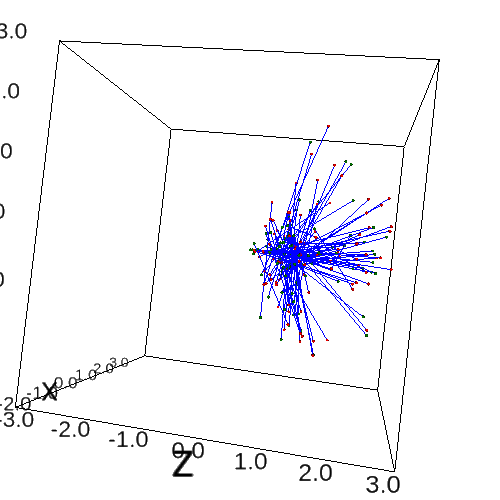

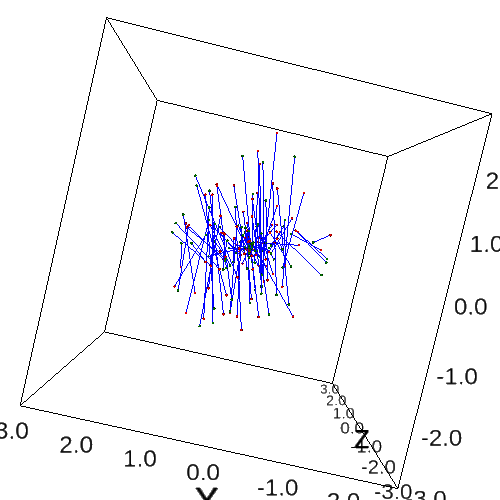

In [37]:
plot_selected_angles_with_3rd_angle_magnitude(mat, angles_true, range(100))

In [41]:
import ipyvolume as ipv

In [42]:
display(ipv.screenshot())

Output()

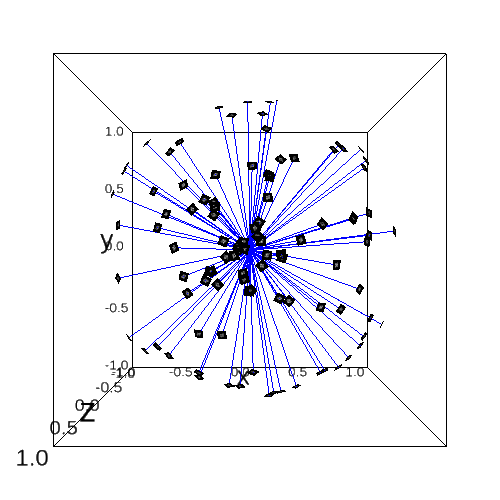

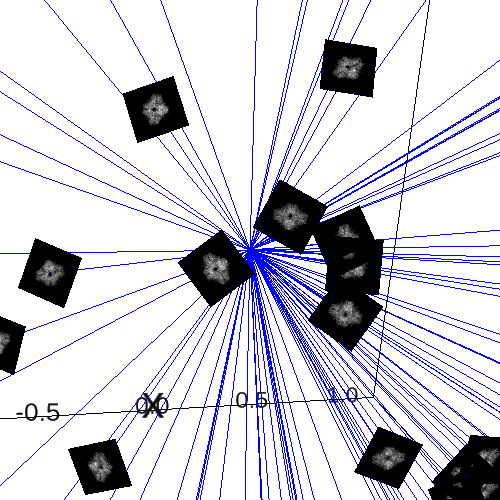

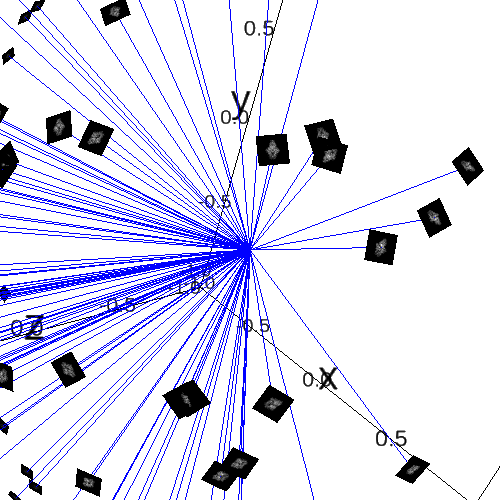

In [43]:
plot_images(mat, projections, indices=range(100),img_size_scale=0.05)

In [46]:
display(ipv.screenshot())

Output()

In [47]:
distance_difference(angles_predicted=mat, angles_true=angles_true)

Mean quaternion distance between true and predicted values:  1.809932162160245  rad ( 103.70147409676976  degrees)


1.809932162160245